In [1]:
import pandas as pd
import numpy as np
import os
import glob

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [2]:
from helpers import *

In [3]:
# df

# Data prep

Läs in fil

In [4]:
df = pd.read_csv('../indata/ODB_TSV/ODB-Sysselsättning efter område, tid, ålder, sysselsättning och kön.txt', sep='\t', header=1)

Specificera indexering

In [5]:
df = df.set_index(['område', 'tid'])

Vänd ner samtliga kolumner i en kolumn

In [6]:
df = pd.DataFrame(df.stack())

Lyft ut index till kolumner igen

In [7]:
df = df.reset_index()

Sätt beskrivande kolumnnamn

In [8]:
df = df.rename(columns={'level_2': 'age_group_gender', 0: 'value', 'tid':'year'})

Splitta områdesnamn till endast baskod

In [9]:
df['område'] = df['område'].str.split(' ', 1, expand = True)
df = df.rename(columns={'område': 'BASKOD2010'})
df['BASKOD2010'] = df['BASKOD2010'].astype(str).astype(int)

Byt om `BASKOD2010` till entity-namnet

In [10]:
df = baskod2010tobasomrade(df)

Splitta ut `ageyeargender` till fyra separata kolumner

In [11]:
df['Kön'] = df['age_group_gender'].str.split().str[-1]

In [12]:
df['agegroup'] = df['age_group_gender'].str.split().str[0]

In [13]:
df['kategori'] = df['age_group_gender'].str.split().str[2:-1].str.join(' ')

Specificera ordningen på kolumnerna

In [14]:
df = df[['basomrade','year','kategori', 'Kön', 'agegroup', 'value']]

Specificera indexering

In [15]:
df = df.set_index(['basomrade'])

    #

In [16]:
df = df.groupby(['basomrade', 'year', 'kategori', 'Kön']).sum().reset_index()

Sätt `Kön` till en pandas category

In [17]:
df['Kön'] = df['Kön'].astype('category')
df['Kön'].cat.categories = ['female', 'male']

# Antal förvärvsarbetande

In [18]:
concept = 'employed_aged_20_64'

In [19]:
nSys = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]

In [20]:
nSys = nSys.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [21]:
byGender(concept, nSys)

Saved employed_aged_20_64_female to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--employed_aged_20_64_female--by--basomrade--year.csv

Saved employed_aged_20_64_male to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--employed_aged_20_64_male--by--basomrade--year.csv



(                        basomrade  year  value
 0             4111110_norra_runby  2000    735
 1             4111110_norra_runby  2001    737
 2             4111110_norra_runby  2002    731
 3             4111110_norra_runby  2003    702
 4             4111110_norra_runby  2004    691
 5             4111110_norra_runby  2005    688
 6             4111110_norra_runby  2006    673
 7             4111110_norra_runby  2007    675
 8             4111110_norra_runby  2008    664
 9             4111110_norra_runby  2009    658
 10            4111110_norra_runby  2010    689
 11            4111120_sodra_runby  2000    110
 12            4111120_sodra_runby  2001    115
 13            4111120_sodra_runby  2002    108
 14            4111120_sodra_runby  2003    101
 15            4111120_sodra_runby  2004    101
 16            4111120_sodra_runby  2005    102
 17            4111120_sodra_runby  2006    107
 18            4111120_sodra_runby  2007     94
 19            4111120_sodra_runby  2008

In [22]:
nSys = nSys.groupby(['basomrade', 'year']).sum().reset_index()

In [23]:
appendNewDatapoints(concept, nSys)

Saved employed_aged_20_64 to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--employed_aged_20_64--by--basomrade--year.csv



,basomrade,year,value
0,4111110_norra_runby,2000,1488
1,4111110_norra_runby,2001,1478
2,4111110_norra_runby,2002,1476
3,4111110_norra_runby,2003,1423
4,4111110_norra_runby,2004,1412
5,4111110_norra_runby,2005,1372
6,4111110_norra_runby,2006,1335
7,4111110_norra_runby,2007,1353
8,4111110_norra_runby,2008,1340
9,4111110_norra_runby,2009,1352


# Antal ej förvärvsarbetande

In [24]:
concept = 'unemployed_aged_20_64'

In [25]:
nNonSys = df[df['kategori'] == 'Ej Förvärvsarbetande']

In [26]:
nNonSys = nNonSys.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [27]:
byGender(concept, nNonSys)

Saved unemployed_aged_20_64_female to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--unemployed_aged_20_64_female--by--basomrade--year.csv

Saved unemployed_aged_20_64_male to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--unemployed_aged_20_64_male--by--basomrade--year.csv



(                        basomrade  year  value
 0             4111110_norra_runby  2000    180
 1             4111110_norra_runby  2001    182
 2             4111110_norra_runby  2002    182
 3             4111110_norra_runby  2003    220
 4             4111110_norra_runby  2004    223
 5             4111110_norra_runby  2005    185
 6             4111110_norra_runby  2006    178
 7             4111110_norra_runby  2007    180
 8             4111110_norra_runby  2008    183
 9             4111110_norra_runby  2009    214
 10            4111110_norra_runby  2010    194
 11            4111120_sodra_runby  2000     25
 12            4111120_sodra_runby  2001     19
 13            4111120_sodra_runby  2002     17
 14            4111120_sodra_runby  2003     19
 15            4111120_sodra_runby  2004     19
 16            4111120_sodra_runby  2005     21
 17            4111120_sodra_runby  2006     22
 18            4111120_sodra_runby  2007     21
 19            4111120_sodra_runby  2008

In [28]:
nNonSys = nNonSys.groupby(['basomrade', 'year']).sum().reset_index()

In [29]:
appendNewDatapoints(concept, nNonSys)

Saved unemployed_aged_20_64 to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--unemployed_aged_20_64--by--basomrade--year.csv



,basomrade,year,value
0,4111110_norra_runby,2000,328
1,4111110_norra_runby,2001,344
2,4111110_norra_runby,2002,345
3,4111110_norra_runby,2003,388
4,4111110_norra_runby,2004,386
5,4111110_norra_runby,2005,357
6,4111110_norra_runby,2006,374
7,4111110_norra_runby,2007,344
8,4111110_norra_runby,2008,339
9,4111110_norra_runby,2009,387


# Andel förvärvsarbetande

In [31]:
concept = 'employment_rate_20_64' #förvärvsarbetande

### Andel per kön

In [32]:
total = df.groupby(['basomrade', 'year', 'Kön']).sum().add_prefix('total_').reset_index()
# total = pd.merge(bygender, df)

In [33]:
bygender = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]
bygender = bygender.groupby(['basomrade', 'year', 'Kön']).sum().reset_index()

In [34]:
bygender = pd.merge(total, bygender)

In [35]:
bygender['rate'] = bygender['value'] / bygender['total_value']

In [36]:
bygender = bygender[['basomrade', 'year', 'Kön', 'rate']]
bygender = bygender.rename(columns={'rate': 'value'})

In [45]:
female, male = byGender(concept, bygender)

Saved employment_rate_20_64_female to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--employment_rate_20_64_female--by--basomrade--year.csv

Saved employment_rate_20_64_male to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--employment_rate_20_64_male--by--basomrade--year.csv



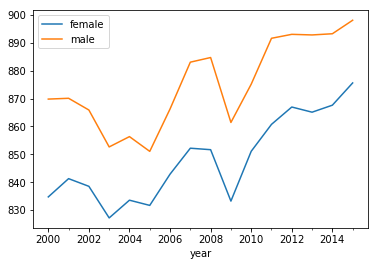

In [46]:
plotcombined(female, 'female')
plotcombined(male, 'male')

### Andel totalt

In [38]:
total = df.groupby(['basomrade', 'year']).sum().add_prefix('total_').reset_index()

In [39]:
rate = df[df['kategori'].isin(['Förvärvsarbetande ej län 01', 'Förvärvsarbetande län 01'])]
rate = rate.groupby(['basomrade', 'year']).sum().reset_index()

In [40]:
rate = pd.merge(total, rate)

In [41]:
rate['rate'] = rate['value'] / rate['total_value']

In [42]:
rate = rate[['basomrade', 'year', 'rate']]
rate = rate.rename(columns={'rate': 'value'})

In [48]:
total = appendNewDatapoints(concept, rate)

Saved employment_rate_20_64 to ../ddf--sodertornsmodellen-output/ddf--sodertornsmodellen--src/ddf--datapoints--employment_rate_20_64--by--basomrade--year.csv



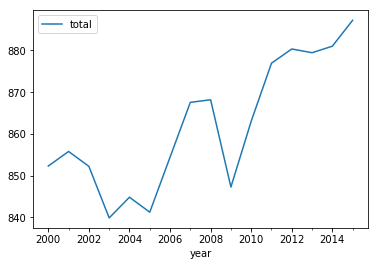

In [49]:
plotcombined(total, 'total')